In [2]:
# Library imports

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

from PIL import Image
import os
import random

2025-03-12 11:07:18.051281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 11:07:18.322261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741777638.423773     661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741777638.453257     661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 11:07:18.713569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

TensorFlow Version: 2.18.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1741777641.190993     661 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
# Load the dataset

dataset = pd.read_csv('rare_species 1/metadata.csv')

# Display the rows and columns of the dataset

print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns)

# EOL means Encyclopedia of Life

Dataset shape: (11983, 7)
Dataset columns: Index(['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum',
       'family', 'file_path'],
      dtype='object')


Displaying image: rare_species 1/chordata_balaenicipitidae/28276513_1049385_eol-full-size-copy.jpg


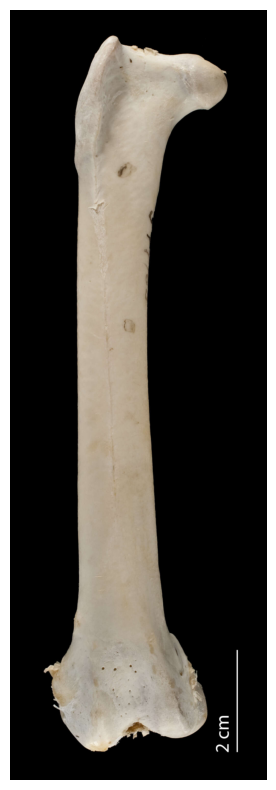

In [5]:
# Path to the folder
image_folder = 'rare_species 1/'

# List all images in the folder
image_files = []
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_files.append(os.path.join(root, file))

# Function to show an image
def show_image(image_path: str) -> None:
    """
    Displays an image given its path.
    """
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # Remove axis for cleaner visualization
    plt.show()

# Show an example
if image_files:
    print(f"Displaying image: {image_files[0]}")
    show_image(image_files[0])
else:
    print("No images found in the folder.")

In [6]:
len(image_files)

11983

In [7]:
# Check the unique values of the columns,
# seeing which can be one-hot encoded

#print("rare_species_id unique values:", dataset['rare_species_id'].nunique())
#print("eol_content_id unique values:", dataset['eol_content_id'].nunique())

print("eol_page_id unique values:", dataset['eol_page_id'].nunique())
#print("kingdom unique values:", dataset['kingdom'].nunique())
print("phylum unique values:", dataset['phylum'].nunique())

print("file_path unique values:", dataset['file_path'].nunique())

print("family unique values:", dataset['family'].nunique())

eol_page_id unique values: 400
phylum unique values: 5
file_path unique values: 11983
family unique values: 202


In [8]:
print("phylum values:", dataset['phylum'].unique())

phylum values: ['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']


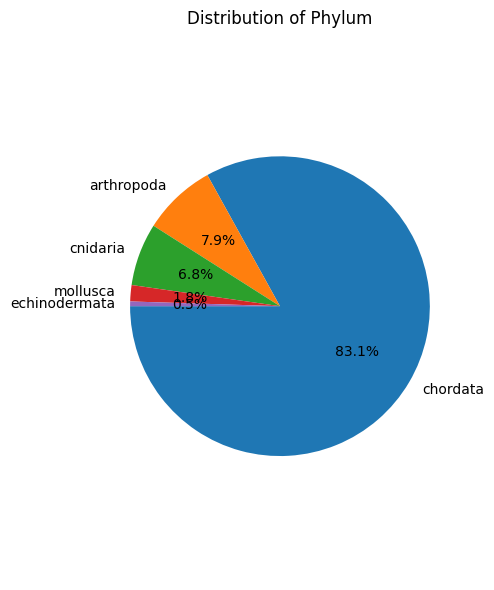

In [9]:
# Plot of the distribution of the 'phylum' column, represented in a pie chart

plt.figure(figsize=(5, 6))
phylum_counts = dataset['phylum'].value_counts()
plt.pie(phylum_counts, labels=phylum_counts.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Phylum')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [51]:
# Selecting the features and the target variable

# Select features excluding 'rare_species_id', 'eol_content_id', and 'kingdom'
X = dataset.iloc[:, [2, 4]].values  # Selecting 'eol_page_id' and 'phylum' as features

# Extract the desired part from the 'file_path' column
def extract_info(file_path):
    return file_path.split('/')[0].split('_')[1]

# Apply the extraction logic
info = np.array([extract_info(path) for path in dataset['file_path']])

# Extract 'family' as the target
y = dataset['family'].values  # 'family' column as the target

In [52]:
print(info[:5])

['unionidae' 'geoemydidae' 'cryptobranchidae' 'turdidae' 'indriidae']


In [ ]:
print(len(np.unique(info)))

# (family)

202


In [55]:
print(dataset['file_path'].head())

0    mollusca_unionidae/12853737_449393_eol-full-si...
1    chordata_geoemydidae/20969394_793083_eol-full-...
2    chordata_cryptobranchidae/28895411_319982_eol-...
3    chordata_turdidae/29658536_45510188_eol-full-s...
4    chordata_indriidae/21252576_7250886_eol-full-s...
Name: file_path, dtype: object


In [56]:
# file_path structure:
# phylum_family/eol_content_id_eol_page_id
# (no new information can be extracted by the file_path column)

In [57]:
# Display the first few rows of the features and target variable
print("Features (X):", X[:5])
print("Target (y):", y[:5])

Features (X): [[449393 'mollusca']
 [793083 'chordata']
 [319982 'chordata']
 [45510188 'chordata']
 [7250886 'chordata']]
Target (y): ['unionidae' 'geoemydidae' 'cryptobranchidae' 'turdidae' 'indriidae']


In [58]:
# Reshape 'extracted_info' to a column vector (2D array)
extracted_info_reshaped = info.reshape(-1, 1)

# Concatenate the two arrays
X = np.concatenate((X, extracted_info_reshaped), axis=1)

In [59]:
# Display the first few rows of the features and target variable
print("Features (X):", X[:5])
print("Target (y):", y[:5])

Features (X): [[449393 'mollusca' 'unionidae']
 [793083 'chordata' 'geoemydidae']
 [319982 'chordata' 'cryptobranchidae']
 [45510188 'chordata' 'turdidae']
 [7250886 'chordata' 'indriidae']]
Target (y): ['unionidae' 'geoemydidae' 'cryptobranchidae' 'turdidae' 'indriidae']


In [ ]:
print("kingdom unique values:", dataset['kingdom'].unique())
print("eol_content_id unique values:", dataset['eol_content_id'].nunique())
print("rare_species id unique values", dataset['rare_species_id'].nunique())

# Do we really need the 'kingdom', 'eol_content_id' and 'rare_species_id' columns?

kingdom unique values: ['animalia']
eol_content_id unique values: 11983
rare_species id unique values 11983


In [ ]:
# Drop the 'file_path' column from 'X' as it is not adding any new information

X = np.delete(X, 2, axis=1)  # Remove the 'file_path' column
print("Features (X):", X[:5])
print("Target (y):", y[:5])

Features (X): [[449393 'mollusca']
 [793083 'chordata']
 [319982 'chordata']
 [45510188 'chordata']
 [7250886 'chordata']]
Target (y): ['unionidae' 'geoemydidae' 'cryptobranchidae' 'turdidae' 'indriidae']


In [64]:
# List the number of columns of X and y

print(X.shape)
print(y.shape)

(11983, 2)
(11983,)


In [83]:
# Transforming categorical data into numerical data
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(drop="first"), [1])],  # Only select the 'phylum' column
    remainder='passthrough'
)

X = np.array(ct.fit_transform(X))

# Display the transformed feature set
print(X[:5])

[[0.0 0.0 0.0 1.0 449393]
 [0.0 1.0 0.0 0.0 793083]
 [0.0 1.0 0.0 0.0 319982]
 [0.0 1.0 0.0 0.0 45510188]
 [0.0 1.0 0.0 0.0 7250886]]


In [ ]:
print(len(np.unique(X)))
print(len(np.unique(X[:, 4]))) # 'eol_page_id' unique values

402
400


In [ ]:
# Display sample images with file names
def show_images(images, n=5):
    plt.figure(figsize=(24, 12))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        image = Image.open(os.path.join(image_folder, images[i]))
        plt.imshow(image)
        plt.axis('off')
    
        # Display the file path directly
        plt.title(images[i], fontsize=8)  # Display filename as title

    plt.tight_layout()
    plt.show()

print("Displaying sample train images:")
show_images(X[:, -1])